# Nowcasting LSTM Implementation

Long short-term memory (LSTM) units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. 
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications

## Nowcasting 

Now casting is a technique in which the probability of occurrence of large magnitude earthquakes is found by computing the cumulative distribution of small earthquakes that occur between large magnitude earthquakes. To compute this cumulative distribution, the number of small earthquakes are tabulated to find the probability distribution function and subsequently cumulative distribution function is found. Once, we have this cumulative distribution, we can use it to find, what is the probability that large earthquake will occur next.

# Importing libraries and settings

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, date
import math
from sklearn.utils import resample
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

Using TensorFlow backend.


## Function to get dataset

Data is obtained from United States Geological Survey [1], the latitude range for the earthquake occurences is 20°S and 40°S and longitude range is 70°E to 105°E
<img src="./dataset.png">

In [6]:
def get_dataset():
    # read data from csv file
    data = pd.read_csv("./query_large.csv", sep=",")
    
    # use data after 1973, because before 1973 only above 5 mag earthquake were recorded
    data = data[296:]
    
    data = data.iloc[::-1]
    print('Raw Data: first 20 rows')
    print(data.head(30))
    X = np.array(data["mag"])
    
    #get first magnitude 5 earthquake, and start from there
    for i in range(len(X)):
        if X[i] >= 5:
            X = X[i+1:]
            break
    
    
    count = 0
    ans = []
    
    #get count of small earthquakes between two large earthquakes
    for i in range(len(X)):
        if X[i] < 5:
            count = count + 1
        else:
            ans.append(count)
            count = 0
     
    data_f = pd.DataFrame(data = ans, columns = ['timeSinceLast'])
    return data_f

In [7]:
dataset = get_dataset()

Raw Data: first 20 rows
                           time  latitude  longitude   depth  mag magType  \
19158  2018-04-11T00:59:46.580Z   36.5595    71.3211  235.61  4.2      mb   
19157  2018-04-10T14:14:20.750Z   24.1268    82.5576   10.00  4.6      mb   
19156  2018-04-10T11:47:03.610Z   33.5112    73.4652   30.92  3.6      mb   
19155  2018-04-09T00:35:19.060Z   37.1200    71.2586  109.70  4.3      mb   
19154  2018-04-08T17:40:09.410Z   22.5859    96.0631   10.00  4.5      mb   
19153  2018-04-08T06:01:18.200Z   36.4910    71.1513  107.92  4.2      mb   
19152  2018-04-07T14:41:57.680Z   37.3343    72.2373  226.05  4.6      mb   
19151  2018-04-04T15:21:23.390Z   24.8474    95.3484  126.09  4.6      mb   
19150  2018-04-04T02:35:41.880Z   37.5062    72.1920  191.20  4.2      mb   
19149  2018-04-03T16:59:30.030Z   29.8972    95.0012   25.59  4.1      mb   
19148  2018-04-02T15:00:19.030Z   37.3024    71.8571  149.53  4.1      mb   
19147  2018-04-02T11:42:10.790Z   26.4555    96.9769

## Some preprocessing and separating to test and train

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Length of traing and test dataset')
print(len(train), len(test))

Length of traing and test dataset
1289 635


## Function to create inputs and outputs

In [11]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [21]:
look_back = 5
time_steps = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], time_steps, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0] ,time_steps, testX.shape[1]))
print('training data shape:' + str(trainX.shape) + '=> ' + str(trainX.shape[0]) + ' is the number of training samples and '+ str(trainX.shape[1]) + ' is timestep and '+ str(trainX.shape[2]) + ' is the number of lookbacks')
print('training data shape:' + str(trainX.shape) + '=> ' + str(testX.shape[0]) + ' is the number of test samples and '+ str(testX.shape[1]) + ' is timestep and '+ str(testX.shape[2]) + ' is the number of lookbacks')

training data shape:(1283, 1, 5)=> 1283 is the number of training samples and 1 is timestep and 5 is the number of lookbacks
training data shape:(1283, 1, 5)=> 629 is the number of test samples and 1 is timestep and 5 is the number of lookbacks


In [15]:
model = Sequential()
model.add(LSTM(64, input_shape=( 1,look_back )))


model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=None)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

newTrainY = trainY.reshape(-1)
newTestY = testY.reshape(-1)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
newTrainY = scaler.inverse_transform([newTrainY])
testPredict = scaler.inverse_transform(testPredict)
newTestY = scaler.inverse_transform([newTestY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(newTrainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(newTestY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.44 RMSE
Test Score: 6.16 RMSE


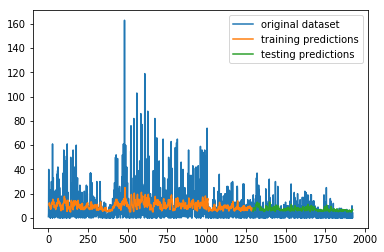

In [16]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan

trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label = 'original dataset')
plt.plot(trainPredictPlot, label = 'training predictions')
plt.plot(testPredictPlot, label = 'testing predictions')
plt.legend()
plt.savefig('fig7',dpi=1024)
plt.show()